In [5]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [6]:
# Data Preparation
# Use PyTorch's ImageFolder and DataLoader to handle the dataset.

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

# Split the dataset into training (80%) and test (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Model Architecture
# Define the neural network model - CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 11)  # 11 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [8]:
# Training the Model
# Set up the loss function and optimizer, then train the model.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 1.2502977916929456
Epoch 2, Loss: 0.7820802522147143
Epoch 3, Loss: 0.6752361350589329
Epoch 4, Loss: 0.587757377801118
Epoch 5, Loss: 0.5265376754381038
Epoch 6, Loss: 0.47496695623353674
Epoch 7, Loss: 0.4284381416660768
Epoch 8, Loss: 0.3845260553061962
Epoch 9, Loss: 0.3437085832876188
Epoch 10, Loss: 0.30657075832839364


In [9]:
# Evaluating the Model
# Evaluate the model's performance on the test set.

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 85.81%


These are some example images from the dataset. Below are their predicted and actual labels


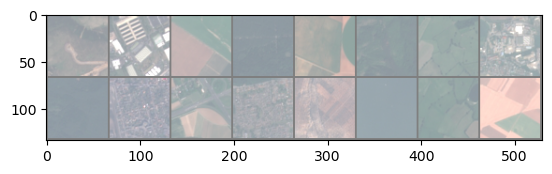

GroundTruth/True Labels:  HerbaceousVegetation Industrial AnnualCrop Forest AnnualCrop Forest Pasture Industrial Forest Residential Highway Residential PermanentCrop SeaLake Pasture AnnualCrop
Predicted:  HerbaceousVegetation Industrial AnnualCrop Forest AnnualCrop Forest Pasture Industrial Forest Residential Highway Residential PermanentCrop SeaLake Pasture AnnualCrop

 Summary: By comparing the True Labels and the Predicted Labels, one can see that for these 16 example images, the model accurately predicted 100% of the time.


In [57]:
# Visualizing Results
# Show some example images along with their predicted and actual labels.
print("These are some example images from the dataset. Below are their predicted and actual labels")
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Print images and labels
imshow(torchvision.utils.make_grid(images[:16]))
print('GroundTruth/True Labels: ', ' '.join('%5s' % dataset.classes[labels[j]] for j in range(16)))

# Show predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % dataset.classes[predicted[j]] for j in range(16)))

print('\n', 'Summary: By comparing the True Labels and the Predicted Labels, one can see that for these 16 example images, the model accurately predicted 100% of the time.')

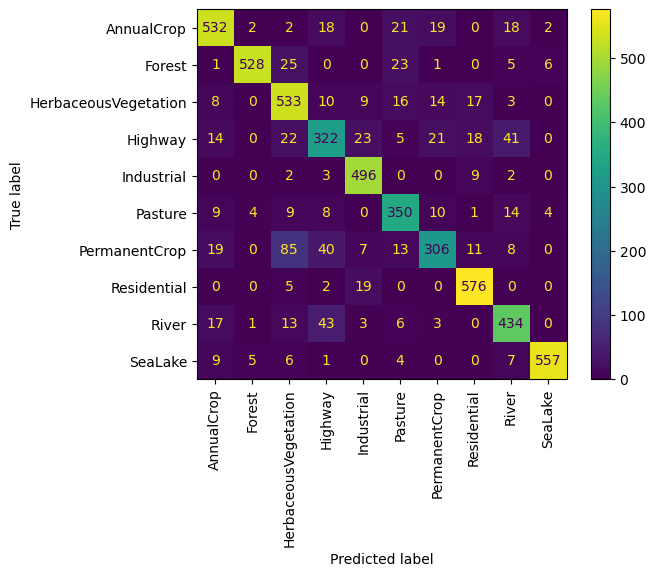


 Summary: The way to interpret this confusion matrix is: Example - AnnualCrop was correctly predicted as AnnualCrop 532 times, misclassified as Forest 2 times, and misclassified as Residential 0 times, etc.


In [59]:
# Confusion Matrix
# Generate and visualize the confusion matrix.

cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
cm_display.plot(xticks_rotation='vertical')
plt.show()

print("\n", "Summary: The way to interpret this confusion matrix is: Example - AnnualCrop was correctly predicted as AnnualCrop 532 times, misclassified as Forest 2 times, and misclassified as Residential 0 times, etc.")
